<a href="https://colab.research.google.com/github/skywalker0803r/deep-learning-ian-goodfellow/blob/master/LSTNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F 
import requests
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from torch.utils.data import TensorDataset,DataLoader   
import datetime
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from copy import deepcopy
import matplotlib.pyplot as plt

# get model
exec(requests.get('https://raw.githubusercontent.com/skywalker0803r/LSTNet.pytorch/master/LSTNet.py').text)
model = LSTNet(num_features=5,output_out_features=1)

# get data
start,end = datetime.datetime(2010,1,1),datetime.date.today()
df = web.DataReader("6005.tw", "yahoo", start, end).drop('Adj Close',axis=1)
df.head()

,High,Low,Open,Close,Volume
Date,,,,,
2010-01-04,17.158199,16.606100,16.903400,16.818501,34331786.0
2010-01-05,17.200701,16.563601,16.988300,16.860901,25989593.0
2010-01-06,17.413000,16.648600,16.945900,17.115700,28718524.0
2010-01-07,17.158199,16.606100,17.158199,16.606100,21070925.0
2010-01-08,16.945900,16.393700,16.648600,16.733500,18418517.0


In [2]:
def make_data_iter(df,ss_x,time_step=48):
  data = {'x':[],'y':[]}
  for t in range(len(df)-time_step):
    data['x'].append(ss_x.transform(df.iloc[t:t+time_step,:].values))
    data['y'].append(df.iloc[[t+time_step],:][['Close']].values)
  data['x'] = np.array(data['x'])
  data['y'] = np.array(data['y'])
  print(data['x'].shape,data['y'].shape)
  data = TensorDataset(torch.FloatTensor(data['x']),torch.FloatTensor(data['y']))
  data_iter = DataLoader(data,batch_size=64)
  return data_iter

def split_df(df):
  sp1 = int(len(df)*0.8)
  sp2 = int(len(df)*0.9)
  train = df.iloc[:sp1]
  valid = df.iloc[sp1:sp2]
  test = df.iloc[sp2:]
  return train,valid,test

In [3]:
# split data
train,valid,test = split_df(df)
# use train_data make scaler
ss_x = StandardScaler().fit(train)
# apply scaler and make data_iter
train_iter = make_data_iter(train,ss_x)
valid_iter = make_data_iter(valid,ss_x)
test_iter = make_data_iter(test,ss_x)

(2092, 48, 5) (2092, 1, 1)
(220, 48, 5) (220, 1, 1)
(220, 48, 5) (220, 1, 1)


# test model

In [4]:
for x,y in train_iter:
  y = y.reshape(-1,1)
  print(x.shape,y.shape)
  y_hat = model(x)
  print(y_hat.shape)
  break

torch.Size([64, 48, 5]) torch.Size([64, 1])
torch.Size([64, 1])


# loss and optimizer

In [5]:
loss_fn = lambda a,b:((a-b)**2).mean()
optimizer = Adam(model.parameters(),lr=0.001)

# train_loop

In [6]:
def train_loop(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    
    for epoch in range(num_epochs):
        # train
        net.train()
        train_loss = 0
        t = 0
        for x,y in train_iter:
            loss = loss_function(net(x),y.reshape(-1,1))
            # weight update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # record loss
            train_loss += loss.item()
            t += 1
        train_history.append(train_loss/t)
        
        # eval
        net.eval()
        valid_loss = 0
        t = 0
        for x,y in valid_iter:
            loss = loss_function(net(x),y)
            # record loss
            valid_loss += loss.item()
            t += 1
        valid_history.append(valid_loss/t)
        
        # print the epoch loss
        print("epochs {} train loss {:.4f} valid loss {:.4f}".format(
            epoch,train_history[-1],valid_history[-1]))
        
        # record best_net
        if valid_history[-1] <= best_loss:
            best_loss = valid_history[-1]
            best_net = deepcopy(net.eval())
            print('record net')
    
    # when end all epoch plot history
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    # return best_net
    return best_net

epochs 0 train loss 90.5460 valid loss 33.0686
record net
epochs 1 train loss 24.4144 valid loss 2.9590
record net
epochs 2 train loss 4.8115 valid loss 0.1530
record net
epochs 3 train loss 1.6484 valid loss 0.1728
epochs 4 train loss 0.9916 valid loss 0.0574
record net
epochs 5 train loss 0.7301 valid loss 0.0585
epochs 6 train loss 0.6288 valid loss 0.0521
record net
epochs 7 train loss 0.5975 valid loss 0.0505
record net
epochs 8 train loss 0.5719 valid loss 0.0448
record net
epochs 9 train loss 0.5487 valid loss 0.0482
epochs 10 train loss 0.5531 valid loss 0.0490
epochs 11 train loss 0.5322 valid loss 0.0500
epochs 12 train loss 0.5386 valid loss 0.0503
epochs 13 train loss 0.5218 valid loss 0.0514
epochs 14 train loss 0.5092 valid loss 0.0558
epochs 15 train loss 0.4859 valid loss 0.0515
epochs 16 train loss 0.4758 valid loss 0.0611
epochs 17 train loss 0.4916 valid loss 0.0650
epochs 18 train loss 0.4954 valid loss 0.0572
epochs 19 train loss 0.4888 valid loss 0.0678
epochs 20 

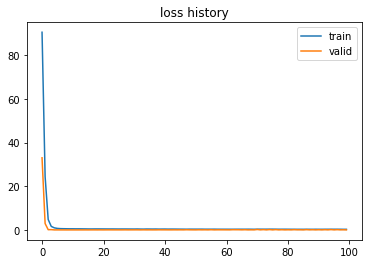

In [7]:
best_model = train_loop(model,train_iter,valid_iter,loss_fn,optimizer,num_epochs=100)

In [8]:
def evaluate(model,data_iter):
  x = data_iter.dataset.tensors[0]
  y = data_iter.dataset.tensors[1]
  y_hat = model(x)
  y_hat = y_hat.detach().numpy().reshape(-1,1)
  y_real = y.detach().numpy().reshape(-1,1)
  plt.plot(y_hat,label='y_hat')
  plt.plot(y_real,label='y_real')
  plt.legend()
  plt.show()

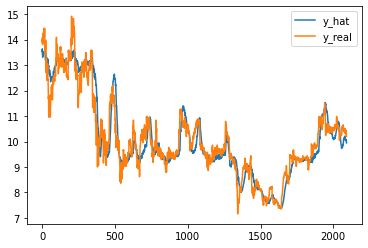

In [9]:
evaluate(best_model,train_iter)

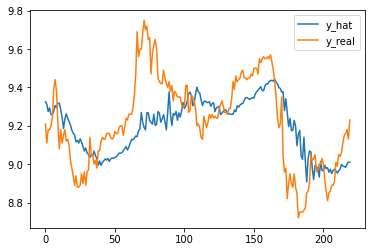

In [10]:
evaluate(best_model,valid_iter)

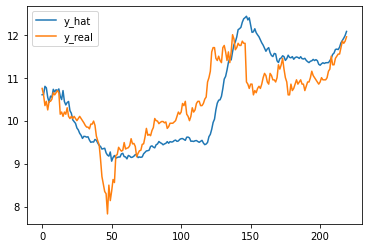

In [11]:
evaluate(best_model,test_iter)